In [1]:
import numpy as np
import pandas as pd
import os

DATASET_SIZE = 6000000

train = pd.read_csv('./Train_Processed_4.23.csv', nrows=DATASET_SIZE)
train.dtypes

Unnamed: 0              int64
key                    object
fare_amount           float64
pickup_datetime        object
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
passenger_count         int64
abs_diff_longitude    float64
abs_diff_latitude     float64
dtype: object

In [2]:
# Add features
    
def add_distances_features(df):
    df['euclidean'] = (df['abs_diff_longitude'] ** 2 + df['abs_diff_latitude'] ** 2) ** 0.5
    df['manhattan'] = df['abs_diff_longitude'] + df['abs_diff_latitude']

def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['pickup_datetime'].apply(lambda x: x.weekday())
    
    # Drop 'pickup_datetime' as we won't need it anymore
    df = df.drop('pickup_datetime', axis=1)
    
add_distances_features(train)
add_time_features(train)
train.dtypes

Unnamed: 0                     int64
key                           object
fare_amount                  float64
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
abs_diff_longitude           float64
abs_diff_latitude            float64
euclidean                    float64
manhattan                    float64
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
dtype: object

In [3]:
# Drop unwanted columns
dropped_columns = ['Unnamed: 0', 'key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                  'dropoff_latitude']

train_clean = train.drop(dropped_columns, axis=1)
train_clean.dtypes

fare_amount           float64
passenger_count         int64
abs_diff_longitude    float64
abs_diff_latitude     float64
euclidean             float64
manhattan             float64
year                    int64
month                   int64
day                     int64
hour                    int64
weekday                 int64
dtype: object

In [4]:
# Get labels

train_labels = train_clean['fare_amount'].values
train_df = train_clean.drop(['fare_amount'], axis=1)

train_df.dtypes

passenger_count         int64
abs_diff_longitude    float64
abs_diff_latitude     float64
euclidean             float64
manhattan             float64
year                    int64
month                   int64
day                     int64
hour                    int64
weekday                 int64
dtype: object

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Scale data
scaler = MinMaxScaler()
train_df_scaled = scaler.fit_transform(train_df)

C:\Users\tty81\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers
from keras import regularizers
# Build DNN model

LEARNING_RATE = 0.001
BATCH_SIZE = 3000
EPOCHS = 20

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=train_df_scaled.shape[1]))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(8, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='linear'))

adam = optimizers.adam(lr=LEARNING_RATE)
model.compile(loss='mse', optimizer=adam, metrics=['mae'])

model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2816      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dens

In [7]:
# Train model
history = model.fit(x=train_df_scaled, y=train_labels, batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, verbose=1, validation_split=0.05, shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 5700000 samples, validate on 300000 samples
Epoch 1/20
5700000/5700000 [==============================] - 24s 4us/step - loss: 52.2420 - mean_absolute_error: 4.6009 - val_loss: 19.6843 - val_mean_absolute_error: 2.1916
Epoch 2/20
5700000/5700000 [==============================] - 20s 4us/step - loss: 19.1614 - mean_absolute_error: 1.9939 - val_loss: 20.0496 - val_mean_absolute_error: 2.1395
Epoch 3/20
5700000/5700000 [==============================] - 20s 4us/step - loss: 18.8975 - mean_absolute_error: 1.9671 - val_loss: 18.2807 - val_mean_absolute_error: 2.0121
Epoch 4/20
5700000/5700000 [==============================] - 20s 4us/step - loss: 18.6992 - mean_absolute_error: 1.9529 - val_loss: 18.0174 - val_mean_absolute_error: 1.9723
Epoch 5/20
5700000/5700000 [==============================] - 20s 4us/step - loss: 18.4803 - mean_absolute_error: 1.9382 - val_loss: 18.1501 - val_mean_absolute_error: 1.9916
Epoch 6/20
5700000/57000

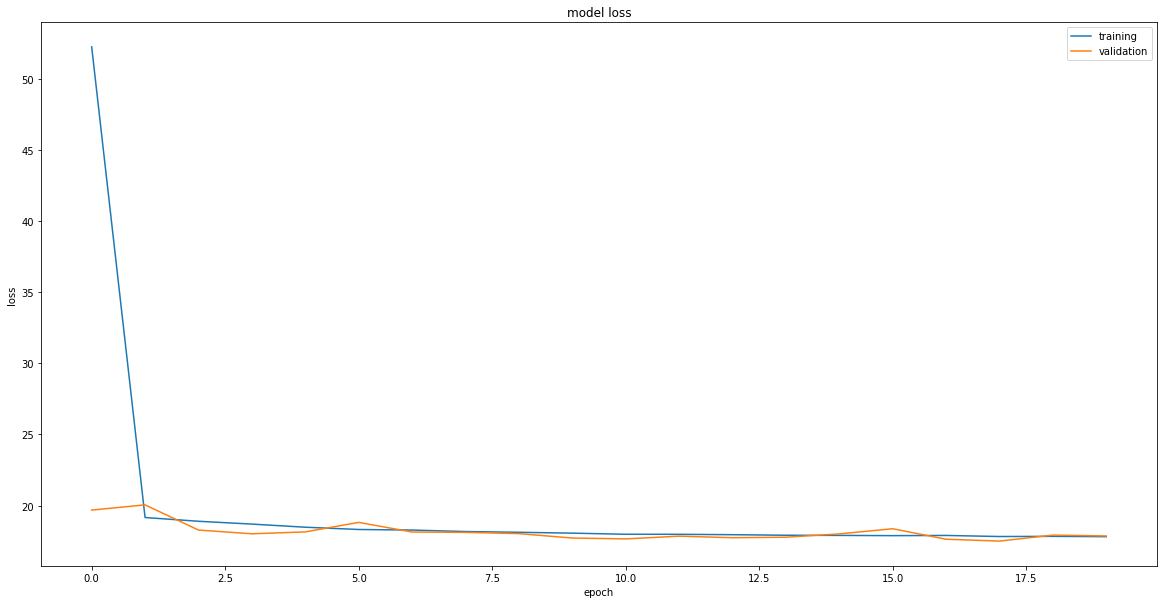

In [15]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    plt.figure(figsize=(20, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='upper right')
    plt.show()

plot_loss_accuracy(history)

In [9]:
test = pd.read_csv('./test.csv')

def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    
add_travel_vector_features(test)

In [10]:
add_distances_features(test)
add_time_features(test)
test.dtypes

key                           object
pickup_datetime       datetime64[ns]
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
passenger_count                int64
abs_diff_longitude           float64
abs_diff_latitude            float64
euclidean                    float64
manhattan                    float64
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
dtype: object

In [11]:
# Drop unwanted columns
dropped_columns = ['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                  'dropoff_latitude']

test_clean = test.drop(dropped_columns, axis=1)
test_clean.dtypes

passenger_count         int64
abs_diff_longitude    float64
abs_diff_latitude     float64
euclidean             float64
manhattan             float64
year                    int64
month                   int64
day                     int64
hour                    int64
weekday                 int64
dtype: object

In [12]:
test_scaled = scaler.transform(test_clean)

In [13]:
prediction = model.predict(test_scaled, batch_size=128, verbose=1)

9914/9914 [==============================] - 0s 21us/step


In [14]:
def output_submission(raw_test, prediction, id_column, prediction_column, file_name):
    df = pd.DataFrame(prediction, columns=[prediction_column])
    df[id_column] = raw_test[id_column]
    df[[id_column, prediction_column]].to_csv((file_name), index=False)
    print('Output complete')

# output prediction
output_submission(test, prediction, 'key', 'fare_amount', 'more_feature_epo20_2.csv')

Output complete
